In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset

dataset = load_dataset("imdb")

print(dataset)
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [4]:
# Creating a validation set from train set
train_test_split = dataset['train'].train_test_split(test_size=0.1, seed=42)

# New data distribution
train_data = train_test_split['train']
val_data = train_test_split['test']
test_data = dataset['test']

In [5]:
# GloVe
import os

target_file = 'glove_data/glove.6B.300d.txt'

# İf file already exists don't download again
if os.path.exists(target_file):
    print("✅ File already exists.")

else:

    !wget http://nlp.stanford.edu/data/glove.6B.zip

    !unzip -q glove.6B.zip -d glove_data

    if os.path.exists("glove.6B.zip"):
        os.remove("glove.6B.zip")

!ls glove_data

--2025-11-26 20:51:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-26 20:51:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-26 20:51:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import re
from collections import Counter

# simple cleaning
def clean_text(text):
    text = text.lower() # All lowercase
    text = re.sub(r'<br />', ' ', text) # remove HTML tags
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only numbers and letters
    return text

# Creating Vocabulary
def build_vocab(datasets, min_freq=2):
    counter = Counter()
    for text in datasets:
        clean = clean_text(text)
        counter.update(clean.split())

    # Special tokens
    # <pad> and <unk>
    vocab = {"<pad>": 0, "<unk>": 1}

    # add words that have at least min_freq
    idx = 2
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1

    return vocab

vocab = build_vocab(train_data['text'])
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 51228


In [7]:
def load_glove_embeddings(vocab, glove_file_path, embedding_dim=300):
    embeddings_index = {}

    # Read'ng GloVe
    with open(glove_file_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Rows: num of words, Columns: 300
    embedding_matrix = np.zeros((len(vocab), embedding_dim))

    hit = 0 # Already in GloVe
    miss = 0 # not in GloVe

    for word, i in vocab.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: # if found
            embedding_matrix[i] = embedding_vector
            hit += 1
        else:
            if word == "<unk>":
                embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))
            miss += 1

    print(f"In GloVe: {hit}, Not in GloVe: {miss}")

    # Convert to PyTorch tensor
    return torch.tensor(embedding_matrix, dtype=torch.float32)

# File path
embedding_matrix = load_glove_embeddings(vocab, 'glove_data/glove.6B.300d.txt', 300)

In GloVe: 43188, Not in GloVe: 8040


In [8]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, embedding_matrix, model_type='lstm'):
        super(RNNModel, self).__init__()

        # Embedding layer
        # GloVe matrix in here
        # freeze=True because of Static
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        # RNN layer
        # model_type variable (LSTM or GRU)
        self.model_type = model_type

        if model_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim,
                               hidden_dim,
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               batch_first=True,
                               dropout=dropout if n_layers > 1 else 0)
        elif model_type == 'gru':
            self.rnn = nn.GRU(embedding_dim,
                              hidden_dim,
                              num_layers=n_layers,
                              bidirectional=bidirectional,
                              batch_first=True,
                              dropout=dropout if n_layers > 1 else 0)
        else:
            raise ValueError("Invalid Model type.")

        # Fully Connected
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        embedded = self.dropout(self.embedding(text))
        if self.model_type == 'lstm':
            # LSTM returns (output, (hidden, cell))
            output, (hidden, cell) = self.rnn(embedded)
        else:
            # GRU only returns (output, hidden) no Cell state
            output, hidden = self.rnn(embedded)

        # Gather results
        # Get the forward and backward hidden states
        hidden_forward = hidden[-2,:,:]
        hidden_backward = hidden[-1,:,:]

        # Concatenate
        cat_hidden = torch.cat((hidden_forward, hidden_backward), dim=1)

        # Classifying
        prediction = self.fc(self.dropout(cat_hidden))

        return prediction

In [9]:
# Hyperparameters
INPUT_DIM = len(vocab)       # Vocabulary size (num of words we know)
EMBEDDING_DIM = 300          # GloVe size must be 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1               # Output (probability between 0 and 1)
N_LAYERS = 2                 # Num of layers
BIDIRECTIONAL = True
DROPOUT = 0.5

# LSTM Model
model_lstm = RNNModel(INPUT_DIM,
                      EMBEDDING_DIM,
                      HIDDEN_DIM,
                      OUTPUT_DIM,
                      N_LAYERS,
                      BIDIRECTIONAL,
                      DROPOUT,
                      embedding_matrix, # GloVe matrix
                      model_type='lstm')

# GRU Model
model_gru = RNNModel(INPUT_DIM,
                     EMBEDDING_DIM,
                     HIDDEN_DIM,
                     OUTPUT_DIM,
                     N_LAYERS,
                     BIDIRECTIONAL,
                     DROPOUT,
                     embedding_matrix, # Same deal
                     model_type='gru')


print(f"LSTM Parametre Count: {sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)}")
print(f"GRU Parametre Count: {sum(p.numel() for p in model_gru.parameters() if p.requires_grad)}")

LSTM Parametre Count: 2720257
GRU Parametre Count: 2040321


In [10]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# Device choice because with CPU it takes too long
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Maximum length
MAX_LEN = 400

def text_pipeline(text):
    clean = clean_text(text)
    tokens = [vocab.get(token, vocab["<unk>"]) for token in clean.split()]
    # If loneger than specified length cut it, else leave it as is
    return tokens[:MAX_LEN]

# Prepare Batch
def collate_batch(batch):
    label_list, text_list = [], []

    for item in batch:
        # IMDb dataset: item['text'] comment, item['label'] grading (0 or 1)
        processed_text = torch.tensor(text_pipeline(item['text']), dtype=torch.int64)
        text_list.append(processed_text)
        label_list.append(item['label'])

    # Convert tags into tensor
    label_list = torch.tensor(label_list, dtype=torch.float32)

    # Add 0 to end of short ones
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)

    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 64

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, num_workers=0)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

'''
print("Current device:", device)
if torch.cuda.is_available():
    print("GPU Model:", torch.cuda.get_device_name(0))
else:
    print("!!! WARNING: Currently using CPU.")
'''


'\nprint("Current device:", device)\nif torch.cuda.is_available():\n    print("GPU Model:", torch.cuda.get_device_name(0))\nelse:\n    print("!!! WARNING: Currently using CPU.")\n'

In [11]:
import torch.optim as optim
import time

# --- Heper Functions ---

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for labels, text in iterator:
        labels = labels.to(device)
        text = text.to(device)

        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for labels, text in iterator:
            labels = labels.to(device)
            text = text.to(device)

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# --- Training phase ---

EPOCHS = 5
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss().to(device)

history = {
    'lstm': {'train_loss': [], 'val_acc': [], 'time': 0},
    'gru': {'train_loss': [], 'val_acc': [], 'time': 0}
}

def run_training(model, model_name):
    print(f"\n--- Training {model_name.upper()} Model ---")


    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()

    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion)

        history[model_name]['train_loss'].append(train_loss)
        history[model_name]['val_acc'].append(valid_acc)

        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {valid_acc*100:.2f}%')

    end_time = time.time()
    elapsed = end_time - start_time
    history[model_name]['time'] = elapsed
    print(f"{model_name.upper()} Training complete! Total time: {elapsed:.2f} seconds")
    return model


model_lstm = RNNModel(len(vocab), 300, 256, 1, 2, True, 0.5, embedding_matrix, 'lstm')
model_gru = RNNModel(len(vocab), 300, 256, 1, 2, True, 0.5, embedding_matrix, 'gru')

# Train LSTM
trained_lstm = run_training(model_lstm, 'lstm')

# Train GRU
trained_gru = run_training(model_gru, 'gru')


--- Training LSTM Model ---
Epoch: 01 | Train Loss: 0.666 | Train Acc: 58.24% | Val Acc: 56.64%
Epoch: 02 | Train Loss: 0.587 | Train Acc: 66.29% | Val Acc: 82.42%
Epoch: 03 | Train Loss: 0.412 | Train Acc: 82.44% | Val Acc: 84.41%
Epoch: 04 | Train Loss: 0.379 | Train Acc: 84.00% | Val Acc: 85.39%
Epoch: 05 | Train Loss: 0.355 | Train Acc: 84.93% | Val Acc: 86.88%
LSTM Training complete! Total time: 326.45 seconds

--- Training GRU Model ---
Epoch: 01 | Train Loss: 0.525 | Train Acc: 72.69% | Val Acc: 86.02%
Epoch: 02 | Train Loss: 0.350 | Train Acc: 85.00% | Val Acc: 88.05%
Epoch: 03 | Train Loss: 0.314 | Train Acc: 86.61% | Val Acc: 86.37%
Epoch: 04 | Train Loss: 0.296 | Train Acc: 87.43% | Val Acc: 89.02%
Epoch: 05 | Train Loss: 0.275 | Train Acc: 88.53% | Val Acc: 88.05%
GRU Training complete! Total time: 259.36 seconds


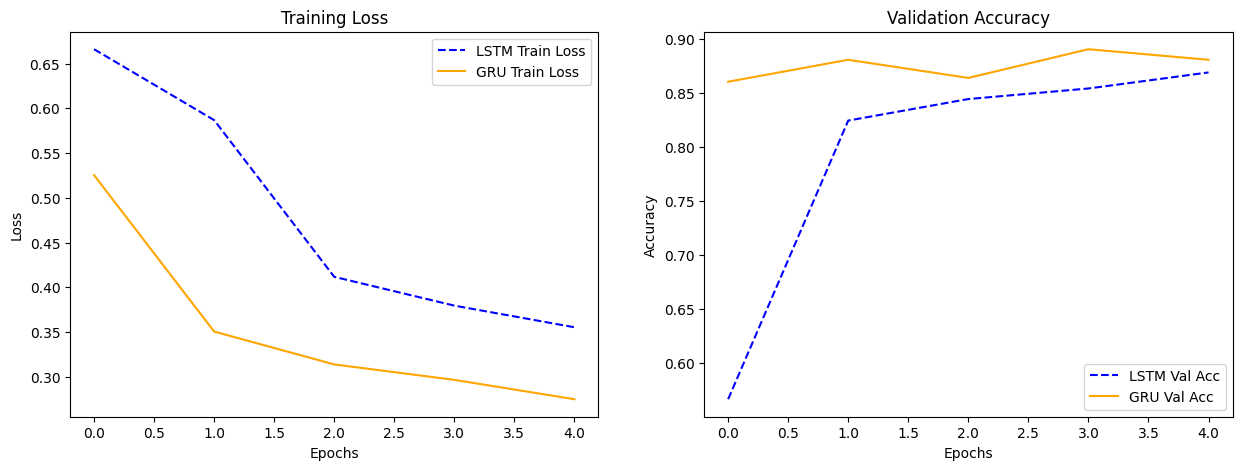

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Graphics: Chage in Loss
    ax[0].plot(history['lstm']['train_loss'], label='LSTM Train Loss', color='blue', linestyle='--')
    ax[0].plot(history['gru']['train_loss'], label='GRU Train Loss', color='orange', linestyle='-')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Graphics: Change in Validation Accuracy
    ax[1].plot(history['lstm']['val_acc'], label='LSTM Val Acc', color='blue', linestyle='--')
    ax[1].plot(history['gru']['val_acc'], label='GRU Val Acc', color='orange', linestyle='-')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

plot_training_history(history)

In [13]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate_test_set(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for labels, text in data_loader:
            labels = labels.to(device)
            text = text.to(device)

            predictions = model(text).squeeze(1)
            # Sigmoid
            rounded_preds = torch.round(torch.sigmoid(predictions))

            all_preds.extend(rounded_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return acc, f1

print("--- TEST RESULTS ---")

# LSTM Test
test_acc_lstm, test_f1_lstm = evaluate_test_set(trained_lstm, test_loader)
print(f"LSTM -> Accuracy: {test_acc_lstm:.4f} | Macro-F1: {test_f1_lstm:.4f}")

# GRU Test
test_acc_gru, test_f1_gru = evaluate_test_set(trained_gru, test_loader)
print(f"GRU  -> Accuracy: {test_acc_gru:.4f} | Macro-F1: {test_f1_gru:.4f}")

--- TEST RESULTS ---
LSTM -> Accuracy: 0.8663 | Macro-F1: 0.8660
GRU  -> Accuracy: 0.8687 | Macro-F1: 0.8676


In [14]:
# Installing Library
!pip install transformers

from transformers import DistilBertTokenizer, DistilBertModel

# distilbert-base-uncased
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
# Setting up the device once again incase anything goes south
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def bert_collate_batch(batch):
    text_list = []
    label_list = []

    for item in batch:
        text_list.append(item['text'])
        label_list.append(item['label'])

    # BERT Tokenizer
    # padding=True: Add 0s based on longest sentence
    # truncation=True: If it is longer than 512 words, cut (BERT's limit is 512)
    # return_tensors='pt': Return as PyTorch tensor
    inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt", max_length=80)

    # Convert tags into tensor
    labels = torch.tensor(label_list, dtype=torch.float32)

    # inputs is a dictianary: {'input_ids': ..., 'attention_mask': ...}
    return inputs['input_ids'].to(device), inputs['attention_mask'].to(device), labels.to(device)

# Update DataLoaders for BERT
# shrink Batch Size relatively since BERT is large (64 -> 32 or 16)
BERT_BATCH_SIZE = 32

train_loader_bert = DataLoader(train_data, batch_size=BERT_BATCH_SIZE, shuffle=True, collate_fn=bert_collate_batch)
val_loader_bert = DataLoader(val_data, batch_size=BERT_BATCH_SIZE, shuffle=False, collate_fn=bert_collate_batch)
test_loader_bert = DataLoader(test_data, batch_size=BERT_BATCH_SIZE, shuffle=False, collate_fn=bert_collate_batch)

In [16]:
import torch.nn as nn

class BERTRNNModel(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers, bidirectional, dropout, model_type='lstm'):
        super(BERTRNNModel, self).__init__()

        # BERT Model
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Return BERT (Not trained, only extract features)
        for param in self.bert.parameters():
            param.requires_grad = False

        # Output size of BERT
        embedding_dim = 768

        # RNN Layer (LSTM or GRU)
        self.model_type = model_type

        if model_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim,
                               hidden_dim,
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               batch_first=True,
                               dropout=dropout if n_layers > 1 else 0)
        elif model_type == 'gru':
            self.rnn = nn.GRU(embedding_dim,
                              hidden_dim,
                              num_layers=n_layers,
                              bidirectional=bidirectional,
                              batch_first=True,
                              dropout=dropout if n_layers > 1 else 0)

        # Output layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        # Flow through BERT
        with torch.no_grad(): # since BERT will not be trained
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # last_hidden_state shape: [batch, sentence length, 768]
        embedded = bert_output.last_hidden_state

        # Flow through RNN (same logic as GloVe)
        if self.model_type == 'lstm':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)

        # Results
        hidden_forward = hidden[-2,:,:]
        hidden_backward = hidden[-1,:,:]
        cat_hidden = torch.cat((hidden_forward, hidden_backward), dim=1)

        # Predict
        prediction = self.fc(self.dropout(cat_hidden))

        return prediction

In [17]:
# Training loop specified for BERT
def train_bert(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for input_ids, attention_mask, labels in iterator:

        optimizer.zero_grad()
        # Two inputs
        predictions = model(input_ids, attention_mask).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_bert(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for input_ids, attention_mask, labels in iterator:
            predictions = model(input_ids, attention_mask).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Start Training

import torch.optim as optim
import time

# Hyperparametrs (kept same as GloVe)
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
EPOCHS = 3

# BERT + LSTM Model
bert_lstm = BERTRNNModel(HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, 'lstm')
bert_lstm = bert_lstm.to(device)

optimizer = optim.Adam(bert_lstm.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss().to(device)

print("\n--- Training BERT + LSTM Model ---")
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_bert(bert_lstm, train_loader_bert, optimizer, criterion)
    valid_loss, valid_acc = evaluate_bert(bert_lstm, val_loader_bert, criterion)
    end_time = time.time()

    print(f'Epoch: {epoch+1:02} | Time: {end_time-start_time:.0f}s | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {valid_acc*100:.2f}%')

# BERT + GRU Model
bert_gru = BERTRNNModel(HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, 'gru')
bert_gru = bert_gru.to(device)

optimizer = optim.Adam(bert_gru.parameters(), lr=0.001)

print("\n--- Training BERT + GRU Model ---")
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_bert(bert_gru, train_loader_bert, optimizer, criterion)
    valid_loss, valid_acc = evaluate_bert(bert_gru, val_loader_bert, criterion)
    end_time = time.time()

    print(f'Epoch: {epoch+1:02} | Time: {end_time-start_time:.0f}s | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {valid_acc*100:.2f}%')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


--- Training BERT + LSTM Model ---
Epoch: 01 | Time: 209s | Train Loss: 0.496 | Train Acc: 75.68% | Val Acc: 80.62%
Epoch: 02 | Time: 170s | Train Loss: 0.427 | Train Acc: 80.30% | Val Acc: 80.58%
Epoch: 03 | Time: 171s | Train Loss: 0.396 | Train Acc: 81.84% | Val Acc: 82.20%

--- Training BERT + GRU Model ---
Epoch: 01 | Time: 165s | Train Loss: 0.481 | Train Acc: 76.23% | Val Acc: 80.06%
Epoch: 02 | Time: 168s | Train Loss: 0.404 | Train Acc: 81.29% | Val Acc: 82.00%
Epoch: 03 | Time: 167s | Train Loss: 0.373 | Train Acc: 83.14% | Val Acc: 83.70%


Features shape: (1024, 512)
Labels shape: (1024,)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipython-input-951413859.py:61: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(


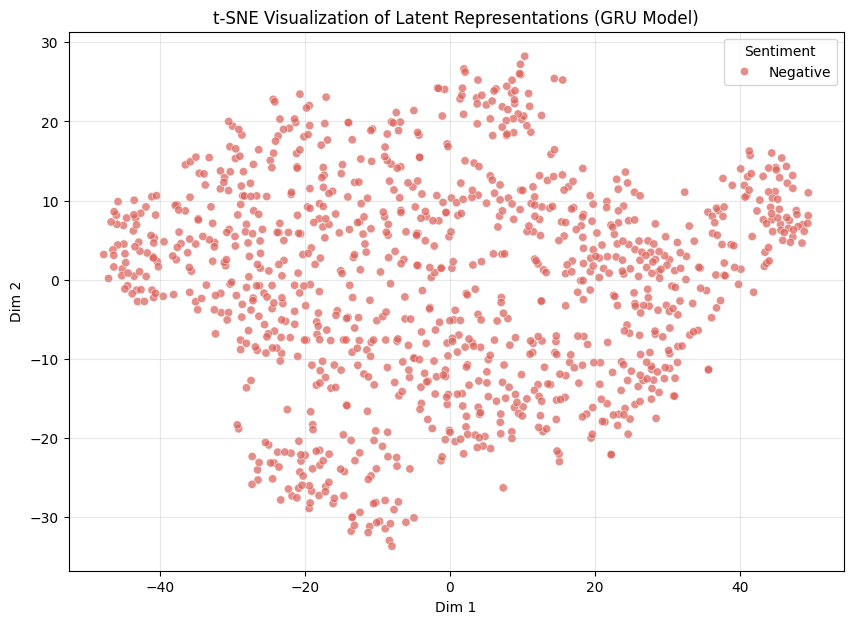

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import seaborn as sns


features = []
labels_list = []

def get_features_hook(module, input, output):
    # hidden state
    features.append(input[0].cpu().detach().numpy())


target_model = trained_gru
target_model.eval()


handle = target_model.fc.register_forward_hook(get_features_hook)

num_samples = 1000
count = 0

with torch.no_grad():
    for labels, text in test_loader:
        labels = labels.to(device)
        text = text.to(device)

        # Run the model
        _ = target_model(text)

        labels_list.extend(labels.cpu().numpy())

        count += len(labels)
        if count >= num_samples:
            break


handle.remove()

# Concatenate lists
features = np.concatenate(features, axis=0)[:count]
labels = np.array(labels_list)[:count]

print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(features)


# Creating DataFrame
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['Sentiment'] = ['Positive' if l == 1 else 'Negative' for l in labels]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Sentiment",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.7
)

plt.title('t-SNE Visualization of Latent Representations (GRU Model)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True, alpha=0.3)
plt.savefig("Q1_tsne_visualization.png")
plt.show()

In [19]:
print("\n--- BERT MODELS TEST RESULTS ---")

# LSTM + BERT Test
test_acc_bert_lstm, test_f1_bert_lstm = evaluate_bert(bert_lstm, test_loader_bert, criterion)
print(f"DistilBERT + Bi-LSTM -> Accuracy: {test_acc_bert_lstm:.4f} | Macro-F1: {test_f1_bert_lstm:.4f}")

# GRU + BERT Test
test_acc_bert_gru, test_f1_bert_gru = evaluate_bert(bert_gru, test_loader_bert, criterion)
print(f"DistilBERT + Bi-GRU  -> Accuracy: {test_acc_bert_gru:.4f} | Macro-F1: {test_f1_bert_gru:.4f}")


--- BERT MODELS TEST RESULTS ---
DistilBERT + Bi-LSTM -> Accuracy: 0.3918 | Macro-F1: 0.8180
DistilBERT + Bi-GRU  -> Accuracy: 0.3776 | Macro-F1: 0.8235
